# What My Goals Are

## Input Data

While the scraper is running, I want to find what my goals are for this project. Since I've stuck to using Earnings Calls, the similarity ratings arent all that interesting - we can find details about the companies and classify them without using NLP at all - they're literally categorized into sectors. 

### Analyst Opinions

These are also not analyst opinions. In the future, I would absolutely want to include analyst opinions, however, for V1 of this project it doesnt make sense. To get a good overview, I'd want multiple different opinions from multiple different sources - I have a list to look at, but these are different websites, and we'd need a different scraper for each one. So thats stressful:) Additionally, sentiments would be the analysts opinion of the company rather than what the earnings said - so it would be more for processing the analysts 

## My Problems

### The calls themselves 
I've tried listening to calls - they're so boring. Everyone tries very hard to be very polite and slippery - "Im not saying anything and Im sure you have a good explanation and its probably a good thing, but it seems youre reporting a lost of billions of dollars, could you please clarify how thats a good thing" 

Theyre exhausting to read and exhausting to listen to. Summarize, please.

### Big Trends? 
There are a lot of companies. I know whats happening with the big tech ones because I've worked near them - but what about the industry? 
Can we find common topics between companies that aren't part of the company definitions - how companies are approaching offices, outsourcing, etc. 

## Steps 

### Topic Analysis 

### Summarizing 
Not easily covered. 


In [75]:
import requests
from bs4 import BeautifulSoup,SoupStrainer
import re
import os 
import sys
import time
import pandas as pd

from IPython.core.debugger import Pdb
from random import Random, randrange

from sklearn.feature_extraction.text import CountVectorizer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from pysentiment2 import LM 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import numpy as np
import math

In [6]:
#open text file in read mode
text_file = open('all_documents_1000.txt', "r")
 
#read whole file to a string
raw_string = text_file.read()
 
#close file
text_file.close()
raw_docs = raw_string.split('\n********************************************************************\n')[1:]

In [7]:
title_file = open('all_titles_1000.txt', 'r')
raw_titles= title_file.read()
title_file.close()
titles = raw_titles.split('\n********************************************************************\n')[1:]


In [8]:
def doc_clean(thing):
    doc = BeautifulSoup(thing, 'html.parser')
    a = doc.prettify()
    a = a.replace(u'\xa0', u' ')
    a = a.replace(u'&amp;',u'and')
    return a


def split_by_sections(doc):
    x = doc.split('<h2>\n')
    details_by_block = {}
    for block in x:
        
        block_2 = block.split('</h2>\n')
        try:
            block_text = block_2[1]
            block_title = block_2[0]
        except:
            block_text = block_2[0]
            block_title = 'header'
        
        details_by_block[block_title]= block_text
    return details_by_block

In [9]:
df_big = {titles[i]:doc_clean(raw_docs[i]) for i in range(0,len(raw_docs))}
docs = list(df_big.values())
doc = docs[0]

In [10]:
print(split_by_sections(doc).keys())
print(split_by_sections(docs[1]).keys())

dict_keys(['header', '  Contents:\n ', '  Prepared Remarks:\n ', '  Questions and Answers:\n ', '  Call participants:\n '])
dict_keys(['header', '  Contents:\n ', '  Prepared Remarks:\n ', '  Questions and Answers:\n ', '  Call participants:\n '])


In [11]:
sections_split = { titles[i]: split_by_sections(docs[i]) for i in range(0, len(docs)) }
sections_split_list = list(sections_split.values())
df = pd.DataFrame(sections_split_list)

In [12]:
df.columns = ['header','toc','prepared_remarks','questions_and_answers','who']
df.head()

,header,toc,prepared_remarks,questions_and_answers,who
0,"<span class=""article-content"">\n <p>\n <stron...",<ul>\n <li>\n Prepared Remarks\n </li>\n ...,<p>\n <strong>\n Operator\n </strong>\n <...,<p>\n <strong>\n Operator\n </strong>\n <...,<p>\n <strong>\n Douglas C. Yearley\n </s...
1,"<span class=""article-content"">\n <p>\n <stron...",<ul>\n <li>\n Prepared Remarks\n </li>\n ...,"<br data-uw-rm-sr="""" role=""presentation""/>\n ...","<br data-uw-rm-sr="""" role=""presentation""/>\n ...",<p>\n <strong>\n Megan Britt\n </strong>\...
2,"<span class=""article-content"">\n <p>\n <stron...",<ul>\n <li>\n Prepared Remarks\n </li>\n ...,<br/>\n <p>\n <strong>\n Operator\n </str...,<br/>\n <p>\n <strong>\n Operator\n </str...,<p>\n <strong>\n Whitney Notaro\n </stron...
3,"<span class=""article-content"">\n <p>\n <stron...",<ul>\n <li>\n Prepared Remarks\n </li>\n ...,"<br data-uw-rm-sr="""" role=""presentation""/>\n ...","<br data-uw-rm-sr="""" role=""presentation""/>\n ...",<p>\n <strong>\n Vince Klinges\n </strong...
4,"<span class=""article-content"">\n <p>\n <stron...",<ul>\n <li>\n Prepared Remarks\n </li>\n ...,"<br data-uw-rm-sr="""" role=""presentation""/>\n ...","<br data-uw-rm-sr="""" role=""presentation""/>\n ...",<p>\n <strong>\n David Atchley\n </strong...


In [104]:
def clean_prepared(pp):
    p = BeautifulSoup(pp, 'html.parser').text
    p = p.replace(u'\n\n', u' ')
    p = p.replace(u'\n', u'')
    try:
        p = p.split('    --     ', 1)[1]
    except:
        p=p
    try:
        p = p.split('     ', 1)[1]
    except:
        p=p
        
    return p


def clean_answers(pp):
    if type(pp) != type('haha'):
        return ''
    p = BeautifulSoup(pp, 'html.parser').text
    p = p.replace(u'\n\n', u' ')
    p = p.replace(u'\n', u'')
    #p = p.split('  --  ')
    return p


def filter_replies(pp):
    p = pp.split('  --  ')
    return ' '.join(list(filter(re.compile(".*Officer.*").match, p)))

def filter_questions(pp):
    p = pp.split('  --  ')
    x = set(list(filter(re.compile(".*~(Officer).*").match, p)))
    p2 = set(p)
    return ' '.join(list(p2.difference(x)))
    
    

In [ ]:
#Lets start with the prepared remarks
p = [clean_prepared(p) for p in list(df['prepared_remarks'])]


In [30]:
analyzer = SentimentIntensityAnalyzer()
regular = [(analyzer.polarity_scores(p[i])) for i in range(0,1000)]

In [38]:
regular[0]

{'neg': 0.028, 'neu': 0.88, 'pos': 0.092, 'compound': 0.999}

In [31]:
#Loughran and McDonald Financial Sentiment Dictionaries 
lm = LM()
tolens = lm.tokenize(p[100])
lm.get_score(tolens)
# Subjectivity: pos + neg / count - so more emotions means higher subjectivity 
# Polarity: between 1 and -1 for pos and negative. This is slightly positive - but nowhere near as positive as the pregular sentimaent analysis 
fin = [(lm.get_score(lm.tokenize(p[i]))) for i in range(0, 1000)]

In [39]:
polarity = [fin[i]['Polarity'] for i in range(0, 1000)]
polarity2 = [regular[i]['compound'] for i in range(0, 1000)]

<AxesSubplot:ylabel='Count'>

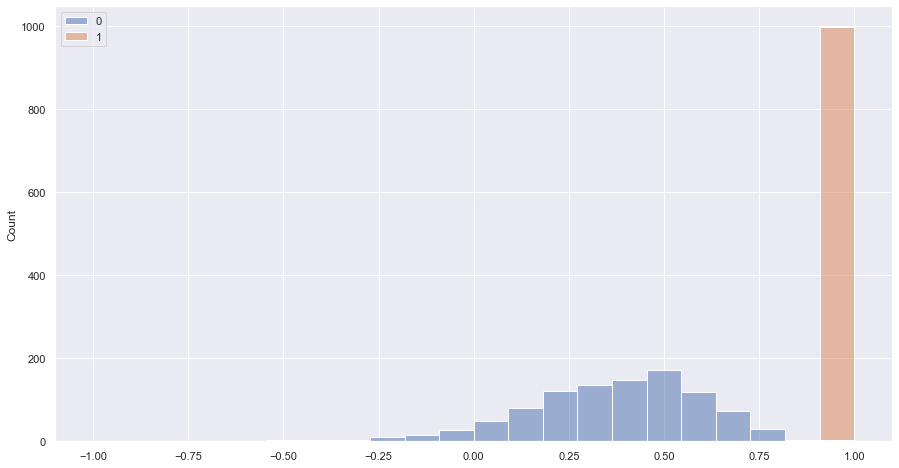

In [42]:
sns.set(rc = {'figure.figsize':(15,8)})
# sns.histplot(x=polarity, kde=True)
# sns.histplot(x=polarity2, kde=True)

sns.histplot([polarity, polarity2], color=['r','b'], alpha=0.5) # Distribution more informative using the financial sentiment analysis.
# And much less positive. Fascinating:) 

In [93]:
questions_and_answers = [clean_answers(p) for p in list(df['questions_and_answers'])]


In [84]:
fin_answers = [(lm.get_score(lm.tokenize(questions_and_answers[i]))) for i in range(0, 1000)]

In [85]:
polarity3 = [fin_answers[i]['Polarity'] for i in range(0, 1000)]

<AxesSubplot:ylabel='Count'>

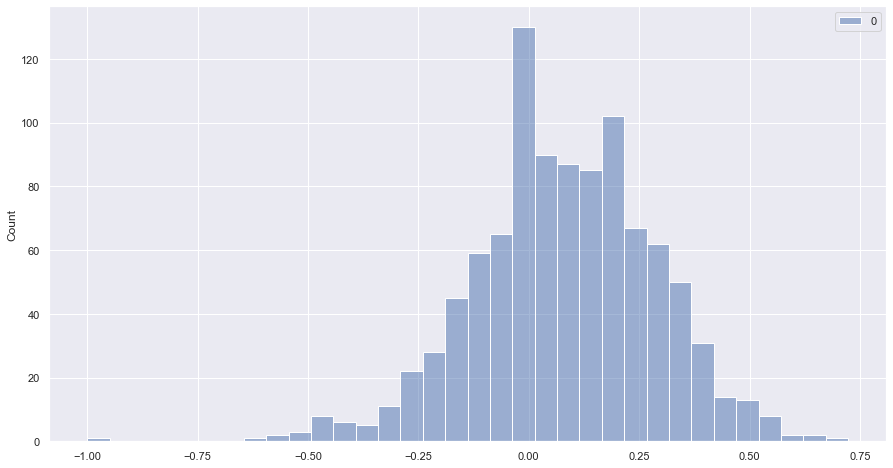

In [86]:
sns.set(rc = {'figure.figsize':(15,8)})
# sns.histplot(x=polarity, kde=True)
# sns.histplot(x=polarity2, kde=True)

sns.histplot([polarity3], color=['r','b'], alpha=0.5) # Distribution more informative using the financial sentiment analysis.
# And much less positive. Fascinating:) 

#The answers are much less positive than the planned. If Im able to isolate the answers only, it may be helpful 

In [100]:
ceo_replies = [filter_replies(i) for i in questions_and_answers ]


fin_answers = [(lm.get_score(lm.tokenize(ceo_replies[i]))) for i in range(0, 1000)]
polarity4 = [fin_answers[i]['Polarity'] for i in range(0, 1000)]

<AxesSubplot:ylabel='Count'>

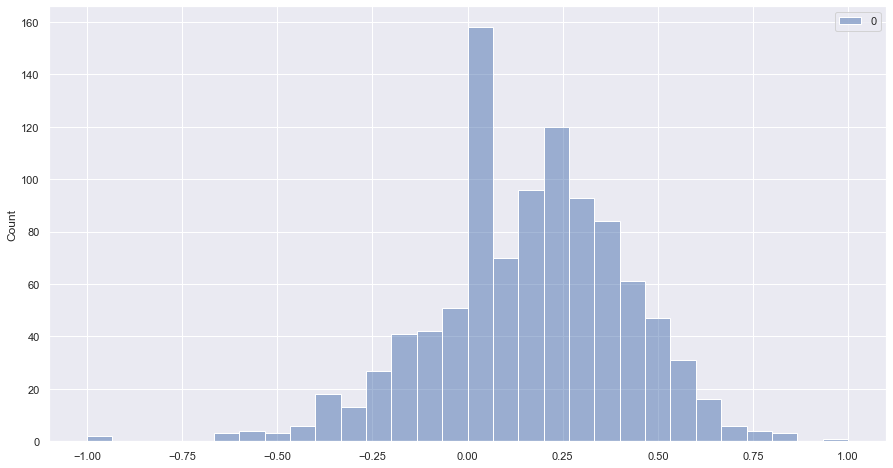

In [101]:
sns.set(rc = {'figure.figsize':(15,8)})
# sns.histplot(x=polarity, kde=True)
# sns.histplot(x=polarity2, kde=True)

sns.histplot([polarity4], color=['r','b'], alpha=0.5) 

In [105]:
analyst_questions = [filter_questions(i) for i in questions_and_answers ]


fin_answers = [(lm.get_score(lm.tokenize(analyst_questions[i]))) for i in range(0, 1000)]
polarity5 = [fin_answers[i]['Polarity'] for i in range(0, 1000)]

<AxesSubplot:ylabel='Count'>

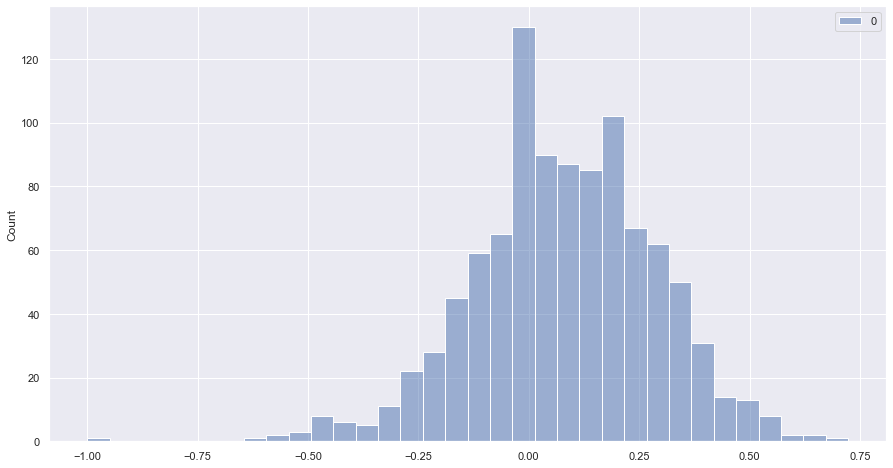

In [106]:
sns.set(rc = {'figure.figsize':(15,8)})
# sns.histplot(x=polarity, kde=True)
# sns.histplot(x=polarity2, kde=True)

sns.histplot([polarity5], color=['r','b'], alpha=0.5) 

#The questions seems a tiny tiny more positive than the answers generally, but the spread is a tiny bit bigger for the ceo replies - possibly due to the higher volume of words - they talk more. 

#

In [108]:
#Lets see if thats due to the sentiment being balanced, or not expressing any
# ceo_replies
# analyst_questions

fin_answers = [(lm.get_score(lm.tokenize(analyst_questions[i]))) for i in range(0, 1000)]
subjectivity_analyst = [fin_answers[i]['Subjectivity'] for i in range(0, 1000)]


fin_answers = [(lm.get_score(lm.tokenize(ceo_replies[i]))) for i in range(0, 1000)]
subjectivity_ceo = [fin_answers[i]['Subjectivity'] for i in range(0, 1000)]


<AxesSubplot:ylabel='Count'>

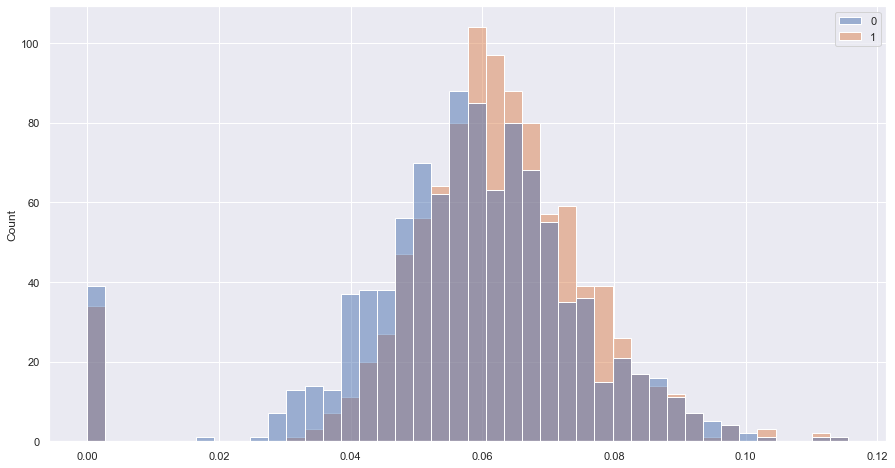

In [109]:
sns.histplot([subjectivity_ceo, subjectivity_analyst], color=['r','b'], alpha=0.5) 
#Not getting a strong sentimentality, possibly due to the large number of trash words. 